In [3]:
# Librerias generales
import pandas as pd
import numpy as np
import json

# Time
import datetime as dt
from datetime import datetime, timedelta

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
from dython.model_utils import roc_graph
from dython.nominal import associations
%matplotlib inline

# OneHotEncoding
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

import os
import json

from pandas.io.json import json_normalize
from datetime import datetime 
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes


from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score


# Algoritmos
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import preprocessing 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# Pipeline
from sklearn.pipeline import make_pipeline

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# Configuración de pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

##### Importar dataset

In [74]:
data = pd.read_excel('six_loan_id.xlsx').drop(['Unnamed: 0'], axis=1)
data.head()

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,total,total_paid
0,241,25718,1076,8,2019-08-14,PAID,16,5947504.88,5947504.88
1,241,25719,1076,9,2019-09-16,PAID,1,5972929.73,5972929.73
2,241,25720,1076,10,2019-10-30,PAID,0,5941645.15,5941645.15
3,241,25721,1076,11,2019-11-29,PAID,0,5939653.40,5939653.40
4,241,25722,1076,12,2019-12-30,PAID,0,5939653.40,5939653.40


In [75]:
# Cambiara formato datatime
#data['paid_date']= pd.to_datetime(data['paid_date']) 
#data['expected_date']= pd.to_datetime(data['expected_date']) 

In [76]:
# Aggregate data on a customer level
data = data.groupby(['client_id', 'loan_id']).agg({
    #'paid_date': lambda x: (datetime.today() - x.max()).days, #Diferenciar entre la fecha actual (hoy) y
    #la fecha de factura más reciente basado en el número de dias de la ultima transacción
    'state': lambda x: x.iloc[-1], # Devuelve el último state
    'arrears_days':'sum',
    'total_paid': 'sum'}).round(0) # Se suman todas las facturas

# Rename columns for easier interpretation
data.rename(columns = {'paid_date': 'recency'}, inplace=True)
# Reset index
data.reset_index(inplace=True)
data.head()

,client_id,loan_id,state,arrears_days,total_paid
0,241,1076,PAID,17,147915805.0
1,241,1244,PAID,23,91852726.0
2,362,1469,PAID,14,15211138.0
3,428,119,PAID,64,8713879.0
4,428,120,PAID,64,8102608.0


In [77]:
#Reemplazar missing values por el promedio
#data.fillna(data.mean(), inplace=True)

In [78]:
data.isnull().sum()

client_id       0
loan_id         0
state           0
arrears_days    0
total_paid      0
dtype: int64

In [79]:
path_file = "data_sempli_holberton.xlsx"
cat_cols = ['ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo',
       'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo',
       'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta',
       'Website empresa', 'Instagram empresa', 'LinkedIn empresa',
       'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas',
       'Impacto', 'Acceso previso a la banca', '# Empleados',
       'Mujeres empresarias', 'Mujeres en cargos directivos']

cat_data = pd.read_excel(path_file, sheet_name = 0, header = 2, usecols = cat_cols).replace('NaT', np.nan)
cat_data = cat_data.sort_values(by='ID Cliente', ascending=True)
rep_columns = ['Procesos judiciales', 'Alertas', 'Website empresa',
               'Instagram empresa', 'LinkedIn empresa',
               'LinkedIn empresarios', 'Impacto', 'Acceso previso a la banca',
               'Mujeres empresarias']
cat_data[rep_columns] = cat_data[rep_columns].replace({'No procesos judiciales':'No',
                                                           'Sí procesos judiciales':'Si',
                                                           'No Alertas':'No',
                                                           'Sí Alertas': 'Si',
                                                           'No website':'No',
                                                           'Si website':'Si',
                                                           'No Ig':'No',
                                                           'Si Ig':'Si',
                                                           'No LinkedIn':'No',
                                                           'Si LinkedIn':'Si',
                                                           'No LinkedIn empresarios':'No',
                                                           'Si LinkedIn empresarios':'Si',
                                                           'Si Impacto':'Si',
                                                           'No Impacto':'No',
                                                           'Si acceso a la banca':'Si',
                                                           'No acceso a la banca':'No',
                                                           'No mujeres empresarias':'No',
                                                           'Si mujeres empresarias':'Si'})
data_transform = pd.DataFrame()
data_transform= data.merge(cat_data, left_on='client_id', right_on='ID Cliente').drop('ID Cliente', axis=1)
data_transform.head(8)

,client_id,loan_id,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,241,1076,PAID,17,147915805.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2
1,241,1244,PAID,23,91852726.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2
2,362,1469,PAID,14,15211138.0,50000000,KT - EX,13 a 24 meses,Servicios,Seed,Medellín,3,No,No,924,2,Si,No,Si,No,32,SocialNetworks,3,No,Si,3,No,0
3,428,119,PAID,64,8713879.0,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0
4,428,120,PAID,64,8102608.0,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0
5,429,998,PAID,65,34013973.0,111491000,SP,Menos de 12 meses,Servicios,Seed,Medellín,4,No,No,951,0,No,No,No,No,49,CreditProfessionalContact,2,No,No,5,No,2
6,429,1512,LATE,42,9890745.0,111491000,SP,Menos de 12 meses,Servicios,Seed,Medellín,4,No,No,951,0,No,No,No,No,49,CreditProfessionalContact,2,No,No,5,No,2
7,430,205,PAID,33,127943202.0,1299370581,KT - CO,Menos de 12 meses,Industria,Venture,Envigado,5,No,Si,810,20,Si,Si,Si,Si,24,Other,3,No,Si,22,No,0


In [80]:
data_transform.shape

(577, 28)

In [89]:
# Se elimina sin INFO de huellas de consulta y score bureau
#normalizada.replace('SIN INFO', np.nan)
data_transform = data_transform[data_transform['Score Bureau Empresa'] != "SIN INFO"]
data_transform = data_transform[data_transform['Huellas de Consulta'] != "SIN INFO"]
#normalizada = normalizada.dropna(how='all', axis=1)
data_transform.shape

(577, 26)

In [82]:
data_transform.columns

Index(['client_id', 'loan_id', 'state', 'arrears_days', 'total_paid', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

In [83]:
#data_transform.reset_index(['client_id', 'loan_id'], inplace=True)
data_transform.set_index(['client_id', 'loan_id'], inplace=True)

In [90]:
data_transform.tail(10)

,,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
client_id,loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,
6385,1476,LATE,152,32829690,300000000,KT - EX,25 a 36 meses,Servicios,Growth,Medellín,4,No,No,920,8,Si,Si,Si,Si,54,SocialNetworks,1,No,Si,30,Si,4
6498,1477,LATE,109,10219933,40000000,KT - EX,13 a 24 meses,Servicios,Seed,Bogotá D.C.,3,No,No,664,3,No,No,No,No,59,CreditProfessionalContact,1,No,Si,5,No,0
6505,1502,LATE,11,44172685,205000000,KT - CO,13 a 24 meses,Comercio,Seed,Medellín,4,Si,No,743,5,Si,No,No,No,44,SocialNetworks,2,No,Si,7,No,0
6526,1490,LATE,99,20352196,100000000,KT - CO,13 a 24 meses,Industria,Venture,Bogotá D.C.,3,No,No,937,3,No,No,No,No,31,Internet,2,No,Si,20,No,1
6663,1488,LATE,88,15288351,60000000,KT - CO,13 a 24 meses,Servicios,Seed,Bogotá D.C.,4,No,Si,934,5,Si,Si,No,Si,38,CommunicationMedia,2,No,Si,9,Si,3
6734,1499,LATE,29,16038476,50000000,KT - CO,13 a 24 meses,Servicios,Seed,Bogotá D.C.,5,No,No,967,2,Si,Si,No,Si,39,SocialNetworks,2,No,Si,6,No,0
6982,1503,LATE,4,36277437,200000000,KT - EX,25 a 36 meses,Servicios,Venture,Bogotá D.C.,4,No,Si,892,5,Si,No,Si,Si,38,CommunicationMedia,1,No,Si,18,No,3
7008,1593,LATE,57,23829284,130000000,CR,25 a 36 meses,Servicios,Venture,Bogotá D.C.,4,No,No,911,2,No,No,No,No,35,Internet,3,Si,Si,14,No,5
7145,1492,PAID,0,85184813,400000000,KT - EX,25 a 36 meses,Servicios,Venture,Medellín,6,No,Si,920,2,Si,Si,No,Si,38,SocialNetworks,2,Si,Si,12,No,9


##### Correlation Between Categorical and Numerical

In [91]:
# Convert all the columns in float to integer for correlation plot as float is not handled
for y in data_transform.columns:
    if(data_transform[y].dtype == np.float64):
        data_transform[y] = data_transform[y].astype(int)

data_transform.dtypes

state                           object
arrears_days                     int64
total_paid                       int32
Monto Acumulado                  int64
Uso de los recursos             object
Plazo                           object
Sector                          object
Ingresos                        object
Ubicación                       object
Estrato Mínimo                   int64
Procesos judiciales             object
Alertas                         object
Score Bureau Empresa            object
Huellas de Consulta             object
Website empresa                 object
Instagram empresa               object
LinkedIn empresa                object
LinkedIn empresarios            object
Edad empresarios                 int64
Activador                       object
Número de accionistas           object
Impacto                         object
Acceso previso a la banca       object
# Empleados                      int64
Mujeres empresarias             object
Mujeres en cargos directi

In [92]:
# Columnas nominales
columnas_OHE = ['state', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación',
                'Procesos judiciales', 'Alertas', 
                'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Activador',
                'Impacto', 'Acceso previso a la banca', 'Mujeres empresarias']

In [93]:
# Seleccionar todo dataframe
Data_Correlation=data_transform.iloc[:,:]

def data_associations():
    associations(Data_Correlation,nominal_columns=columnas_OHE)

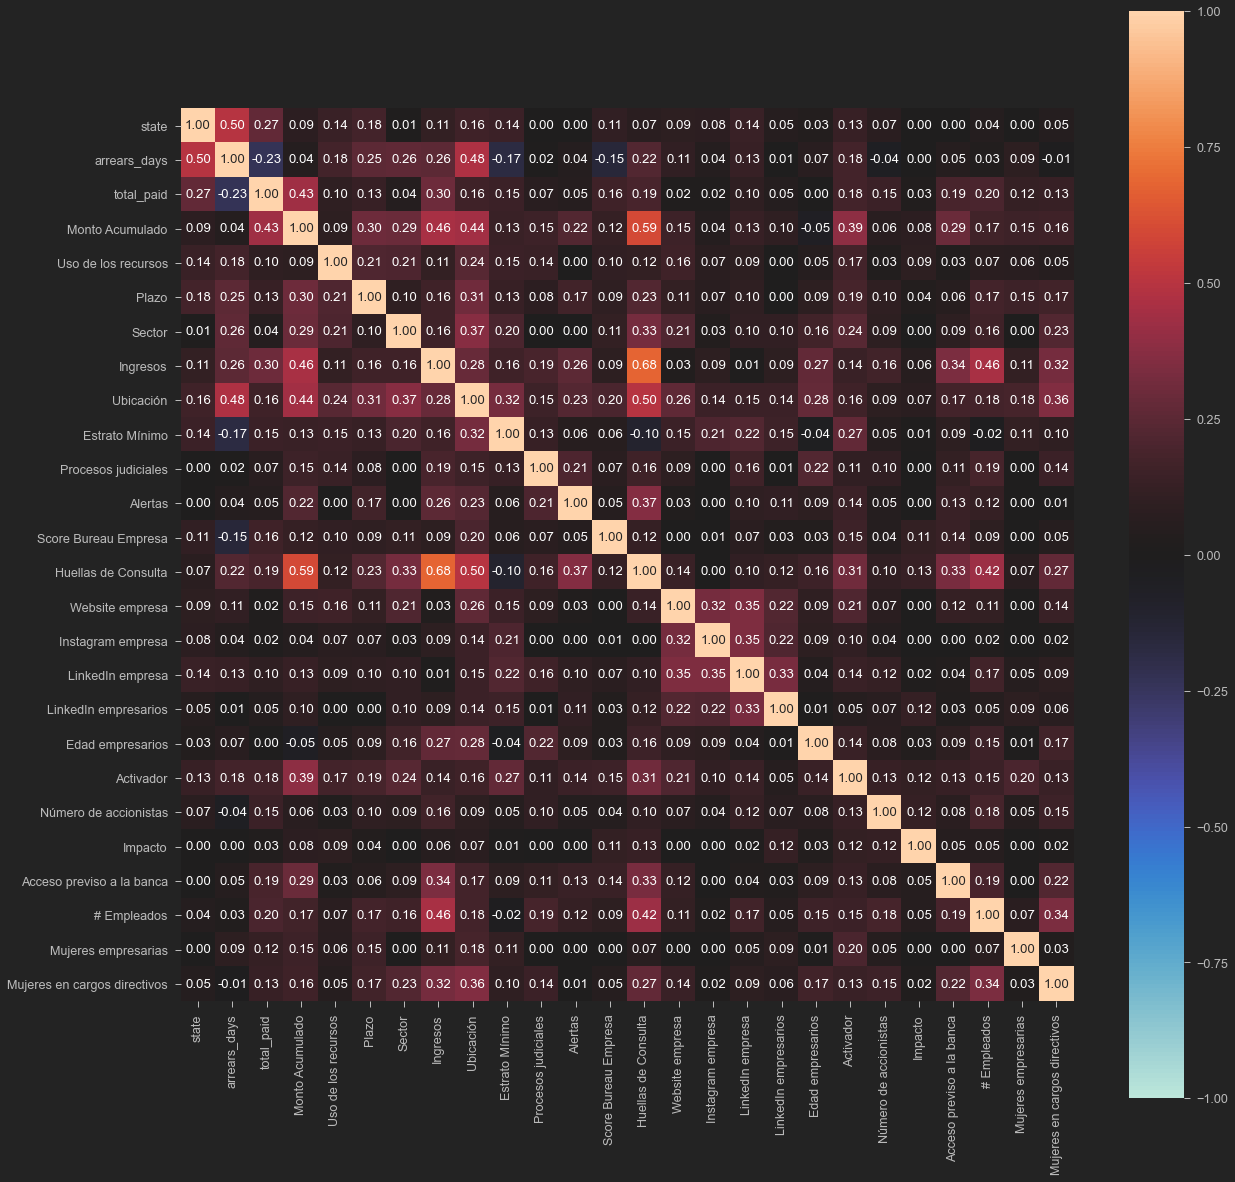

In [94]:
# Graficar correlación entre variables nominales y ordinales
plt.rcParams["figure.figsize"]=20,20
data_associations()

In [95]:
data_transform_2 = data_transform.copy()

In [365]:
data_transform_3 = data_transform_2.copy()

In [366]:
data_transform_3.set_index(['client_id', 'loan_id'], inplace=True)
data_transform_3.drop(['level_0', 'index','cluster_id_3', 'cluster_id_2'],axis=1, inplace=True)
data_transform_3

state  arrears_days  total_paid  Monto Acumulado Uso de los recursos          Plazo     Sector Ingresos    Ubicación  Estrato Mínimo Procesos judiciales Alertas  Score Bureau Empresa  Huellas de Consulta Website empresa Instagram empresa LinkedIn empresa LinkedIn empresarios  Edad empresarios                  Activador  Número de accionistas Impacto Acceso previso a la banca  # Empleados Mujeres empresarias  Mujeres en cargos directivos
client_id loan_id                                                                                                                                                                                                                                                                                                                                                                                                                                                         
241       1076     PAID            17   147915805        250000000                 CR   25 a 36 meses  Servicios     Seed     Medellín               5                  No      No                   925                    8              Si                Si               Si                   Si                45                   Internet                      2      No                        Si           16                  No                             2
          1244     PAID            23    91852726        250000000                 CR   25 a 36 meses  Servicios     Seed     Medellín               5                  No      No                   925                    8              Si                Si               Si                   Si                45                   Internet                      2      No                        Si           16                  No                             2
362       1469     PAID            14    15211138         50000000             KT - EX  13 a 24 meses  Servicios     Seed     Medellín               3                  No      No                   924                    2              Si                No               Si                   No                32             SocialNetworks                      3      No                        Si            3                  No                             0
428       119      PAID            64     8713879         40000000                  SP  13 a 24 meses  Industria     Seed     Medellín               4                  No      No                   861                    1              Si                No               Si                   Si                44  CreditProfessionalContact                      2      No                        Si            5                  No                             0
          120      PAID            64     8102608         40000000                  SP  13 a 24 meses  Industria     Seed     Medellín               4                  No      No                   861                    1              Si                No               Si                   Si                44  CreditProfessionalContact                      2      No                        Si            5                  No                             0
...                 ...           ...         ...              ...                 ...            ...        ...      ...          ...             ...                 ...     ...                   ...                  ...             ...               ...              ...                  ...               ...                        ...                    ...     ...                       ...          ...                 ...                           ...
6734      1499     LATE            29    16038476         50000000             KT - CO  13 a 24 meses  Servicios     Seed  Bogotá D.C.               5                  No      No                   967                    2              Si                Si               No                   Si                39             SocialNetworks        

In [367]:
Num_features=data_transform_3.select_dtypes(include=[np.number]).columns
pt = PowerTransformer()
data_transform_3[Num_features]=pt.fit_transform(data_transform_3[Num_features])
data_transform_3.head()

state  arrears_days  total_paid  Monto Acumulado Uso de los recursos          Plazo     Sector Ingresos Ubicación  Estrato Mínimo Procesos judiciales Alertas  Score Bureau Empresa  Huellas de Consulta Website empresa Instagram empresa LinkedIn empresa LinkedIn empresarios  Edad empresarios                  Activador  Número de accionistas Impacto Acceso previso a la banca  # Empleados Mujeres empresarias  Mujeres en cargos directivos
client_id loan_id                                                                                                                                                                                                                                                                                                                                                                                                                                                      
241       1076     PAID      0.068201    1.990516         0.247658                 CR   25 a 36 meses  Servicios     Seed  Medellín        0.481027                  No      No              0.592443             0.514087              Si                Si               Si                   Si          0.542674                   Internet               0.017484      No                        Si     0.176367                  No                      0.447494
          1244     PAID      0.219112    1.308246         0.247658                 CR   25 a 36 meses  Servicios     Seed  Medellín        0.481027                  No      No              0.592443             0.514087              Si                Si               Si                   Si          0.542674                   Internet               0.017484      No                        Si     0.176367                  No                      0.447494
362       1469     PAID     -0.027869   -0.515458        -1.405435             KT - EX  13 a 24 meses  Servicios     Seed  Medellín       -1.519614                  No      No              0.585245            -0.688637              Si                No               Si                   No         -0.942694             SocialNetworks               0.736474      No                        Si    -1.700640                  No                     -1.459134
428       119      PAID      0.735415   -0.901116        -1.626569                  SP  13 a 24 meses  Industria     Seed  Medellín       -0.523889                  No      No              0.145027            -1.130869              Si                No               Si                   Si          0.451404  CreditProfessionalContact               0.017484      No                        Si    -1.107593                  No                     -1.459134
          120      PAID      0.735415   -0.946665        -1.626569                  SP  13 a 24 meses  Industria     Seed  Medellín       -0.523889                  No      No              0.145027            -1.130869              Si                No               Si                   Si          0.451404  CreditProfessionalContact               0.017484      No                        Si    -1.107593                  No                     -1.459134

#### Data Transformation

In [97]:
# Standardizing all the numerical variables
Num_features=data_transform.select_dtypes(include=[np.number]).columns
data_transform[Num_features]=preprocessing.MinMaxScaler().fit_transform(data_transform[Num_features])
data_transform.head()

state  arrears_days  total_paid  Monto Acumulado Uso de los recursos          Plazo     Sector Ingresos Ubicación  Estrato Mínimo Procesos judiciales Alertas  Score Bureau Empresa  Huellas de Consulta Website empresa Instagram empresa LinkedIn empresa LinkedIn empresarios  Edad empresarios                  Activador  Número de accionistas Impacto Acceso previso a la banca  # Empleados Mujeres empresarias  Mujeres en cargos directivos
client_id loan_id                                                                                                                                                                                                                                                                                                                                                                                                                                                      
241       1076     PAID      0.015697    0.418799         0.173314                 CR   25 a 36 meses  Servicios     Seed  Medellín            0.75                  No      No              0.941955             0.181818              Si                Si               Si                   Si          0.442308                   Internet               0.014706      No                        Si     0.030060                  No                          0.08
          1244     PAID      0.021237    0.260066         0.173314                 CR   25 a 36 meses  Servicios     Seed  Medellín            0.75                  No      No              0.941955             0.181818              Si                Si               Si                   Si          0.442308                   Internet               0.014706      No                        Si     0.030060                  No                          0.08
362       1469     PAID      0.012927    0.043068         0.015756             KT - EX  13 a 24 meses  Servicios     Seed  Medellín            0.25                  No      No              0.940937             0.045455              Si                No               Si                   No          0.192308             SocialNetworks               0.029412      No                        Si     0.004008                  No                          0.00
428       119      PAID      0.059095    0.024672         0.007878                  SP  13 a 24 meses  Industria     Seed  Medellín            0.50                  No      No              0.876782             0.022727              Si                No               Si                   Si          0.423077  CreditProfessionalContact               0.014706      No                        Si     0.008016                  No                          0.00
          120      PAID      0.059095    0.022941         0.007878                  SP  13 a 24 meses  Industria     Seed  Medellín            0.50                  No      No              0.876782             0.022727              Si                No               Si                   Si          0.423077  CreditProfessionalContact               0.014706      No                        Si     0.008016                  No                          0.00

##### Estadística de Hopkins
Prueba la aleatoriedad espacial de los datos e indica la tendencia de agrupación o lo bien que los datos pueden ser agrupados
* 0,5 o menos -->  los datos están distribuidos uniformemente
* 0.77 - 0.99 --> alta tendencia a los cluster 

In [98]:
# Hopkins Statistic is a way of measuring the cluster tendency of a data set.
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan


def hopkins(X):
    d = X.shape[1]
    # d = len(vars) # columns
    n = len(X)  # rows
    m = int(0.1 * n)  # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X, axis=0), np.amax(
            X, axis=0), d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(
            X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H

In [142]:
#Use a random sample of Data for faster computation
data_transform = data_transform.sample(200,random_state=41)
data_transform.head()

,,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
client_id,loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,
5350,1370,LATE,0.063712,0.052596,0.055145,CR,25 a 36 meses,Servicios,Seed,Medellín,0.50,No,No,0.819756,0.000000,Si,Si,No,No,0.115385,Referrer,0.000000,No,Si,0.006012,No,0.00
1467,1309,PAID,0.029548,0.085480,0.102807,SP,Menos de 12 meses,Servicios,Seed,Medellín,0.75,No,Si,0.892057,0.045455,Si,Si,Si,Si,0.250000,FriendOrColleague,0.000000,No,Si,0.016032,No,0.00
1558,692,PAID,0.142198,0.215034,0.387594,KT - CO,Menos de 12 meses,Comercio,Growth,Sabaneta,0.75,Si,Si,0.903259,0.340909,Si,Si,Si,Si,0.769231,CreditProfessionalContact,0.014706,No,Si,0.142285,No,0.12
574,620,LATE,0.172669,0.141789,0.212704,KT - EX,13 a 24 meses,Servicios,Scale Up,Medellín,0.50,No,No,0.822811,0.159091,No,No,No,No,0.057692,Internet,0.014706,No,Si,0.220441,No,0.16
5067,1363,PAID,0.023084,0.078925,0.070901,KT - EX,Menos de 12 meses,Servicios,Seed,Medellín,0.25,No,No,0.954175,0.045455,Si,No,No,No,0.192308,RutaN,0.014706,No,Si,0.022044,Si,0.04


In [143]:
#Resetting the indexs
#data_transform=data_transform.reset_index(drop=True)

In [144]:
# Comprobar estadisticamente si la data si se puede clusterizar
Num_features =data_transform.select_dtypes(include=[np.number]).columns
hopkins(data_transform[Num_features])

0.8544944668204336

####  Data Modelling

In [151]:
#Use a random sample of Data for faster computation
Data = data_transform.sample(200,random_state=41)
Data.head()
#Resetting the indexs
#Data=Data.reset_index(drop=True)

#le = preprocessing.LabelEncoder()
#Data['state'] = le.fit_transform(Data.label.values)

#Rename the levels within in the CancellationCode column
Data['state']=Data['state'].replace(['LATE','PAID'],[0,1])
Data['state']=Data['state'].astype(object)
Data.columns

Index(['state', 'arrears_days', 'total_paid', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

In [163]:
Data

,,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
client_id,loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,
4179,1239,0,0.376731,0.015856,0.094535,CR,25 a 36 meses,Industria,Seed,Medellín,0.50,No,No,0.949084,0.090909,No,Si,No,Si,0.403846,FriendOrColleague,0.000000,Si,Si,0.010020,No,0.00
2440,662,1,0.056325,0.063620,0.128519,KT - EX,13 a 24 meses,Servicios,Seed,Bogotá D.C.,0.75,No,No,0.368635,0.045455,Si,Si,No,No,0.307692,Other,0.000000,No,Si,0.022044,Si,0.04
3262,1440,1,0.000000,0.042900,0.094535,KT - EX,13 a 24 meses,Servicios,Scale Up,Bogotá D.C.,0.75,No,Si,0.713849,0.090909,Si,Si,Si,Si,0.865385,Internet,0.014706,No,Si,0.098196,No,0.16
1663,971,0,0.151431,0.083093,0.252093,CR,Menos de 12 meses,Industria,Scale Up,Itagüí,0.25,No,No,0.950102,0.363636,No,No,No,No,0.326923,CreditProfessionalContact,0.000000,No,Si,0.158317,No,0.08
2460,688,1,0.002770,0.187034,0.330873,CR,13 a 24 meses,Comercio,Scale Up,Medellín,0.75,No,No,0.954175,0.159091,No,No,No,Si,0.365385,CreditProfessionalContact,0.000000,No,Si,0.028056,No,0.12
3423,1115,0,0.015697,0.070427,0.078779,KT - EX,13 a 24 meses,Servicios,Seed,Bogotá D.C.,0.75,No,No,0.765784,0.204545,Si,Si,Si,Si,0.211538,FriendOrColleague,0.029412,No,Si,0.022044,Si,0.20
2454,682,1,0.002770,0.047138,0.039390,KT - EX,Menos de 12 meses,Servicios,Seed,Medellín,0.75,No,No,0.893075,0.022727,No,No,No,No,0.096154,FriendOrColleague,0.014706,No,No,0.008016,Si,0.12
3639,1267,0,0.092336,0.066383,0.015756,KT - CO,Menos de 12 meses,Comercio,Scale Up,Bogotá D.C.,0.50,Si,No,0.941955,0.159091,Si,No,Si,No,0.461538,FriendOrColleague,0.014706,No,Si,0.014028,No,0.00
2461,1422,1,0.000000,0.068639,0.102413,KT - CO,Menos de 12 meses,Servicios,Seed,Medellín,0.50,No,No,0.893075,0.181818,Si,Si,Si,Si,0.173077,FriendOrColleague,0.000000,No,Si,0.034068,No,0.08


In [152]:
#Getting the list of Numerical and Categorical Variables
num_cols = data_transform._get_numeric_data().columns
print (num_cols)
cols = data_transform.columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols



Index(['arrears_days', 'total_paid', 'Monto Acumulado', 'Estrato Mínimo', 'Score Bureau Empresa', 'Huellas de Consulta', 'Edad empresarios', 'Número de accionistas', '# Empleados', 'Mujeres en cargos directivos'], dtype='object')


['state',
 'Mujeres empresarias',
 'Website empresa',
 'Ingresos',
 'LinkedIn empresarios',
 'LinkedIn empresa',
 'Procesos judiciales',
 'Sector',
 'Impacto',
 'Ubicación',
 'Plazo',
 'Activador',
 'Uso de los recursos',
 'Instagram empresa',
 'Acceso previso a la banca',
 'Alertas']

#### Prinicpal Component Analysis¶

In [164]:
#Selection of variables for PCA
Data_pca= Data[['state','arrears_days','total_paid', 'Score Bureau Empresa']]
print (Data_pca.dtypes)

state                    object
arrears_days            float64
total_paid              float64
Score Bureau Empresa    float64
dtype: object


In [165]:
#Principal Component
pca = PCA(n_components=3, whiten=True)
Num_features=Data_pca.select_dtypes(include=[np.number]).columns
x=Data_pca[Num_features]
principalComponents = pca.fit_transform(x)

# Cumulative Explained Variance
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

print(cum_explained_var)

[0.6394403170768321, 0.8983101804384568, 1.0]


In [166]:
#Principal Components converted to a Data frame
principalDf  = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.shape

(200, 3)

In [167]:
principalDf.head(1)

,principal component 1,principal component 2,principal component 3
0,-0.341443,2.140988,0.013449


In [169]:
Data_pca.reset_index(inplace=True)

In [170]:
Data_pca.head(1)

,client_id,loan_id,state,arrears_days,total_paid,Score Bureau Empresa
0,4179,1239,0,0.376731,0.015856,0.949084


In [171]:
Data_pca.drop(['client_id', 'loan_id'], axis= 1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [172]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat = pd.concat([principalDf, Data_pca['state']], axis = 1)
finalDf_Cat.head(2)

,principal component 1,principal component 2,principal component 3,state
0,-0.341443,2.140988,0.013449,0
1,1.893724,-0.541942,-0.231296,1


<function matplotlib.pyplot.show(*args, **kw)>

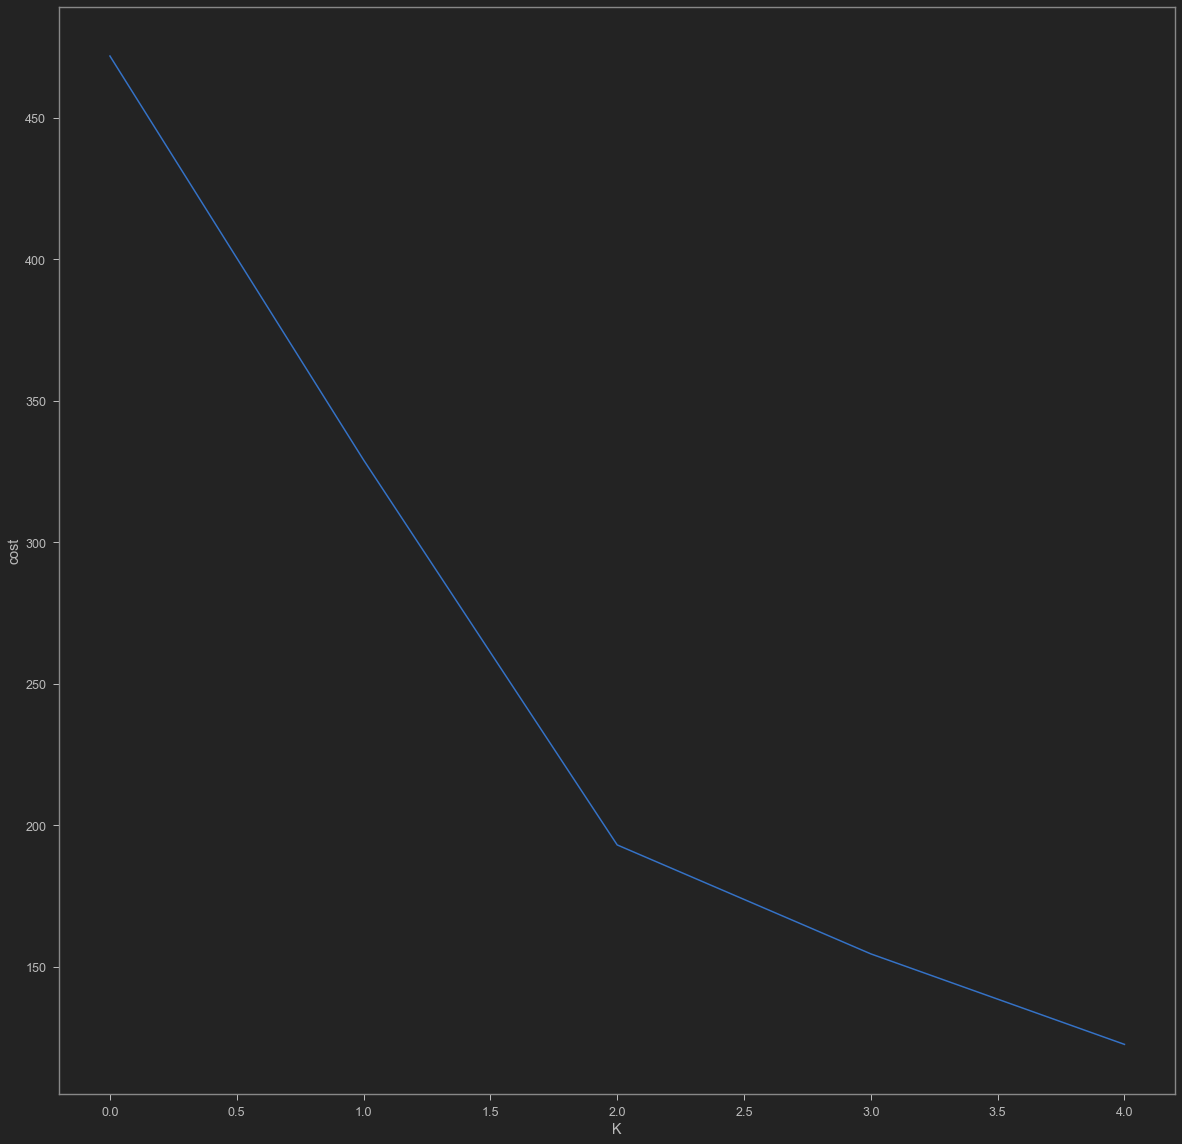

In [173]:
#Choosing optimal K value
cost = []
X = finalDf_Cat
for num_clusters in list(range(2,7)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=15,n_init=50) 
    kproto.fit_predict(X, categorical=[3])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [174]:
# Converting the dataset into matrix
X = finalDf_Cat.to_numpy()

In [177]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=1,gamma=.25) 
clusters = kproto.fit_predict(X, categorical=[3])

1    183
0     17
Name: Cluster_id, dtype: int64


Default bandwidth for data is 0; skipping density estimation.


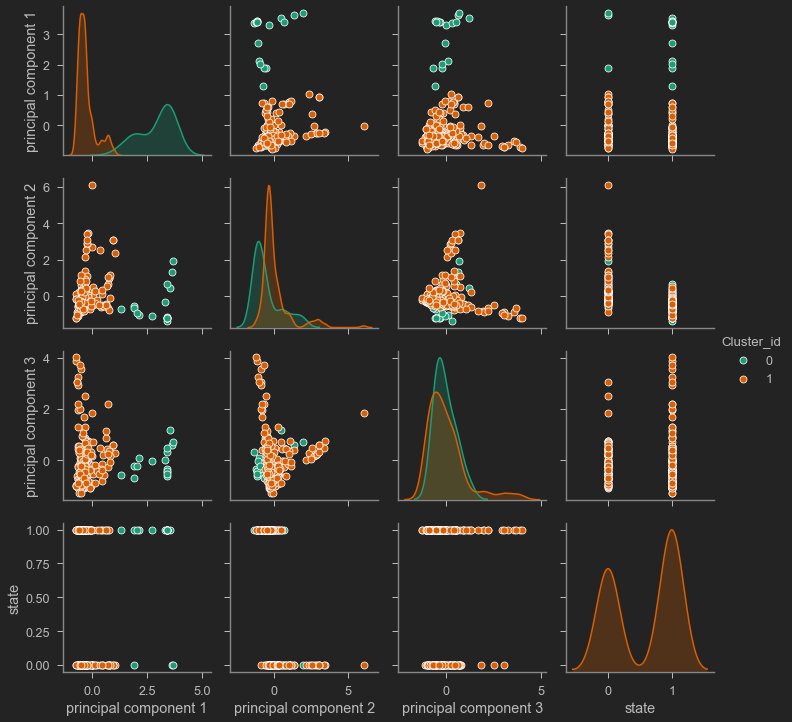

In [178]:
#Visualize K-Prototype clustering on the PCA projected Data
df=pd.DataFrame(finalDf_Cat)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

#### DBSCAN Clustering Algorithm

In [179]:
#Selection of numerical variables for DBSCAN
Data_DBSCAN = Data.select_dtypes(exclude='object')

In [180]:
Data_DBSCAN.head()

,,arrears_days,total_paid,Monto Acumulado,Estrato Mínimo,Score Bureau Empresa,Huellas de Consulta,Edad empresarios,Número de accionistas,# Empleados,Mujeres en cargos directivos
client_id,loan_id,,,,,,,,,,
4179,1239,0.376731,0.015856,0.094535,0.50,0.949084,0.090909,0.403846,0.000000,0.010020,0.00
2440,662,0.056325,0.063620,0.128519,0.75,0.368635,0.045455,0.307692,0.000000,0.022044,0.04
3262,1440,0.000000,0.042900,0.094535,0.75,0.713849,0.090909,0.865385,0.014706,0.098196,0.16
1663,971,0.151431,0.083093,0.252093,0.25,0.950102,0.363636,0.326923,0.000000,0.158317,0.08
2460,688,0.002770,0.187034,0.330873,0.75,0.954175,0.159091,0.365385,0.000000,0.028056,0.12


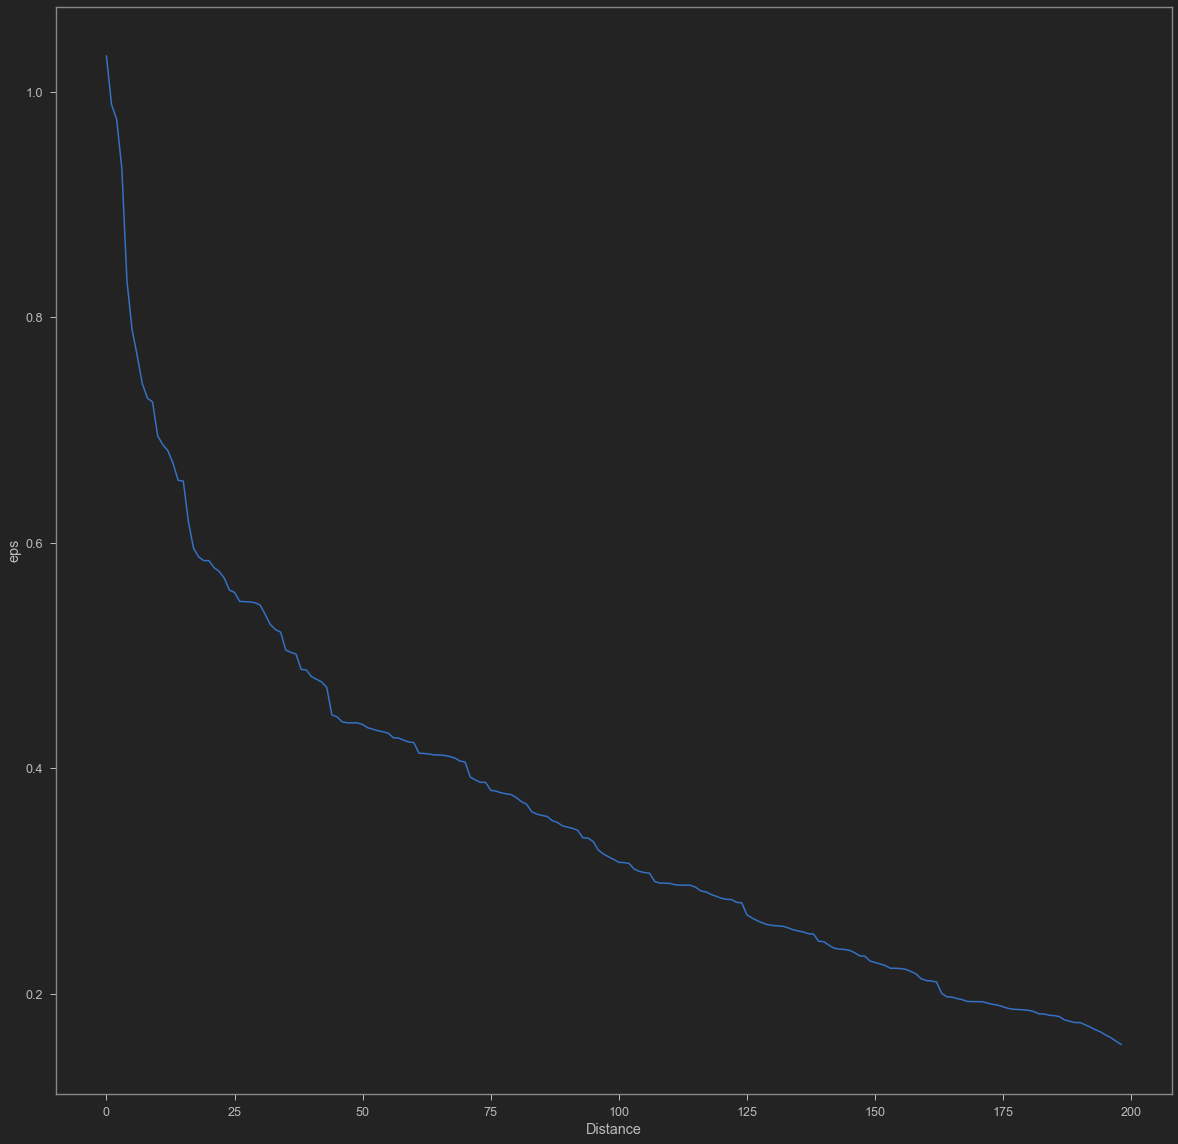

In [181]:
#selection of eps value
from sklearn.neighbors import NearestNeighbors
nbrs=NearestNeighbors().fit(Data_DBSCAN)
distances, indices = nbrs.kneighbors(Data_DBSCAN,20)
kDis = distances[:,10]
kDis.sort()
kDis = kDis[range(len(kDis)-1,0,-1)]
plt.plot(range(0,len(kDis)),kDis)
plt.xlabel('Distance')
plt.ylabel('eps')
plt.show()

In [184]:
#DBSCAN Algorithm
from sklearn.cluster import DBSCAN
dbs_1= DBSCAN(eps=0.6, min_samples=4)
results = dbs_1.fit(Data_DBSCAN).labels_


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0    195
-1      5
Name: Cluster_id_DBSCAN, dtype: int64


Default bandwidth for data is 0; skipping density estimation.


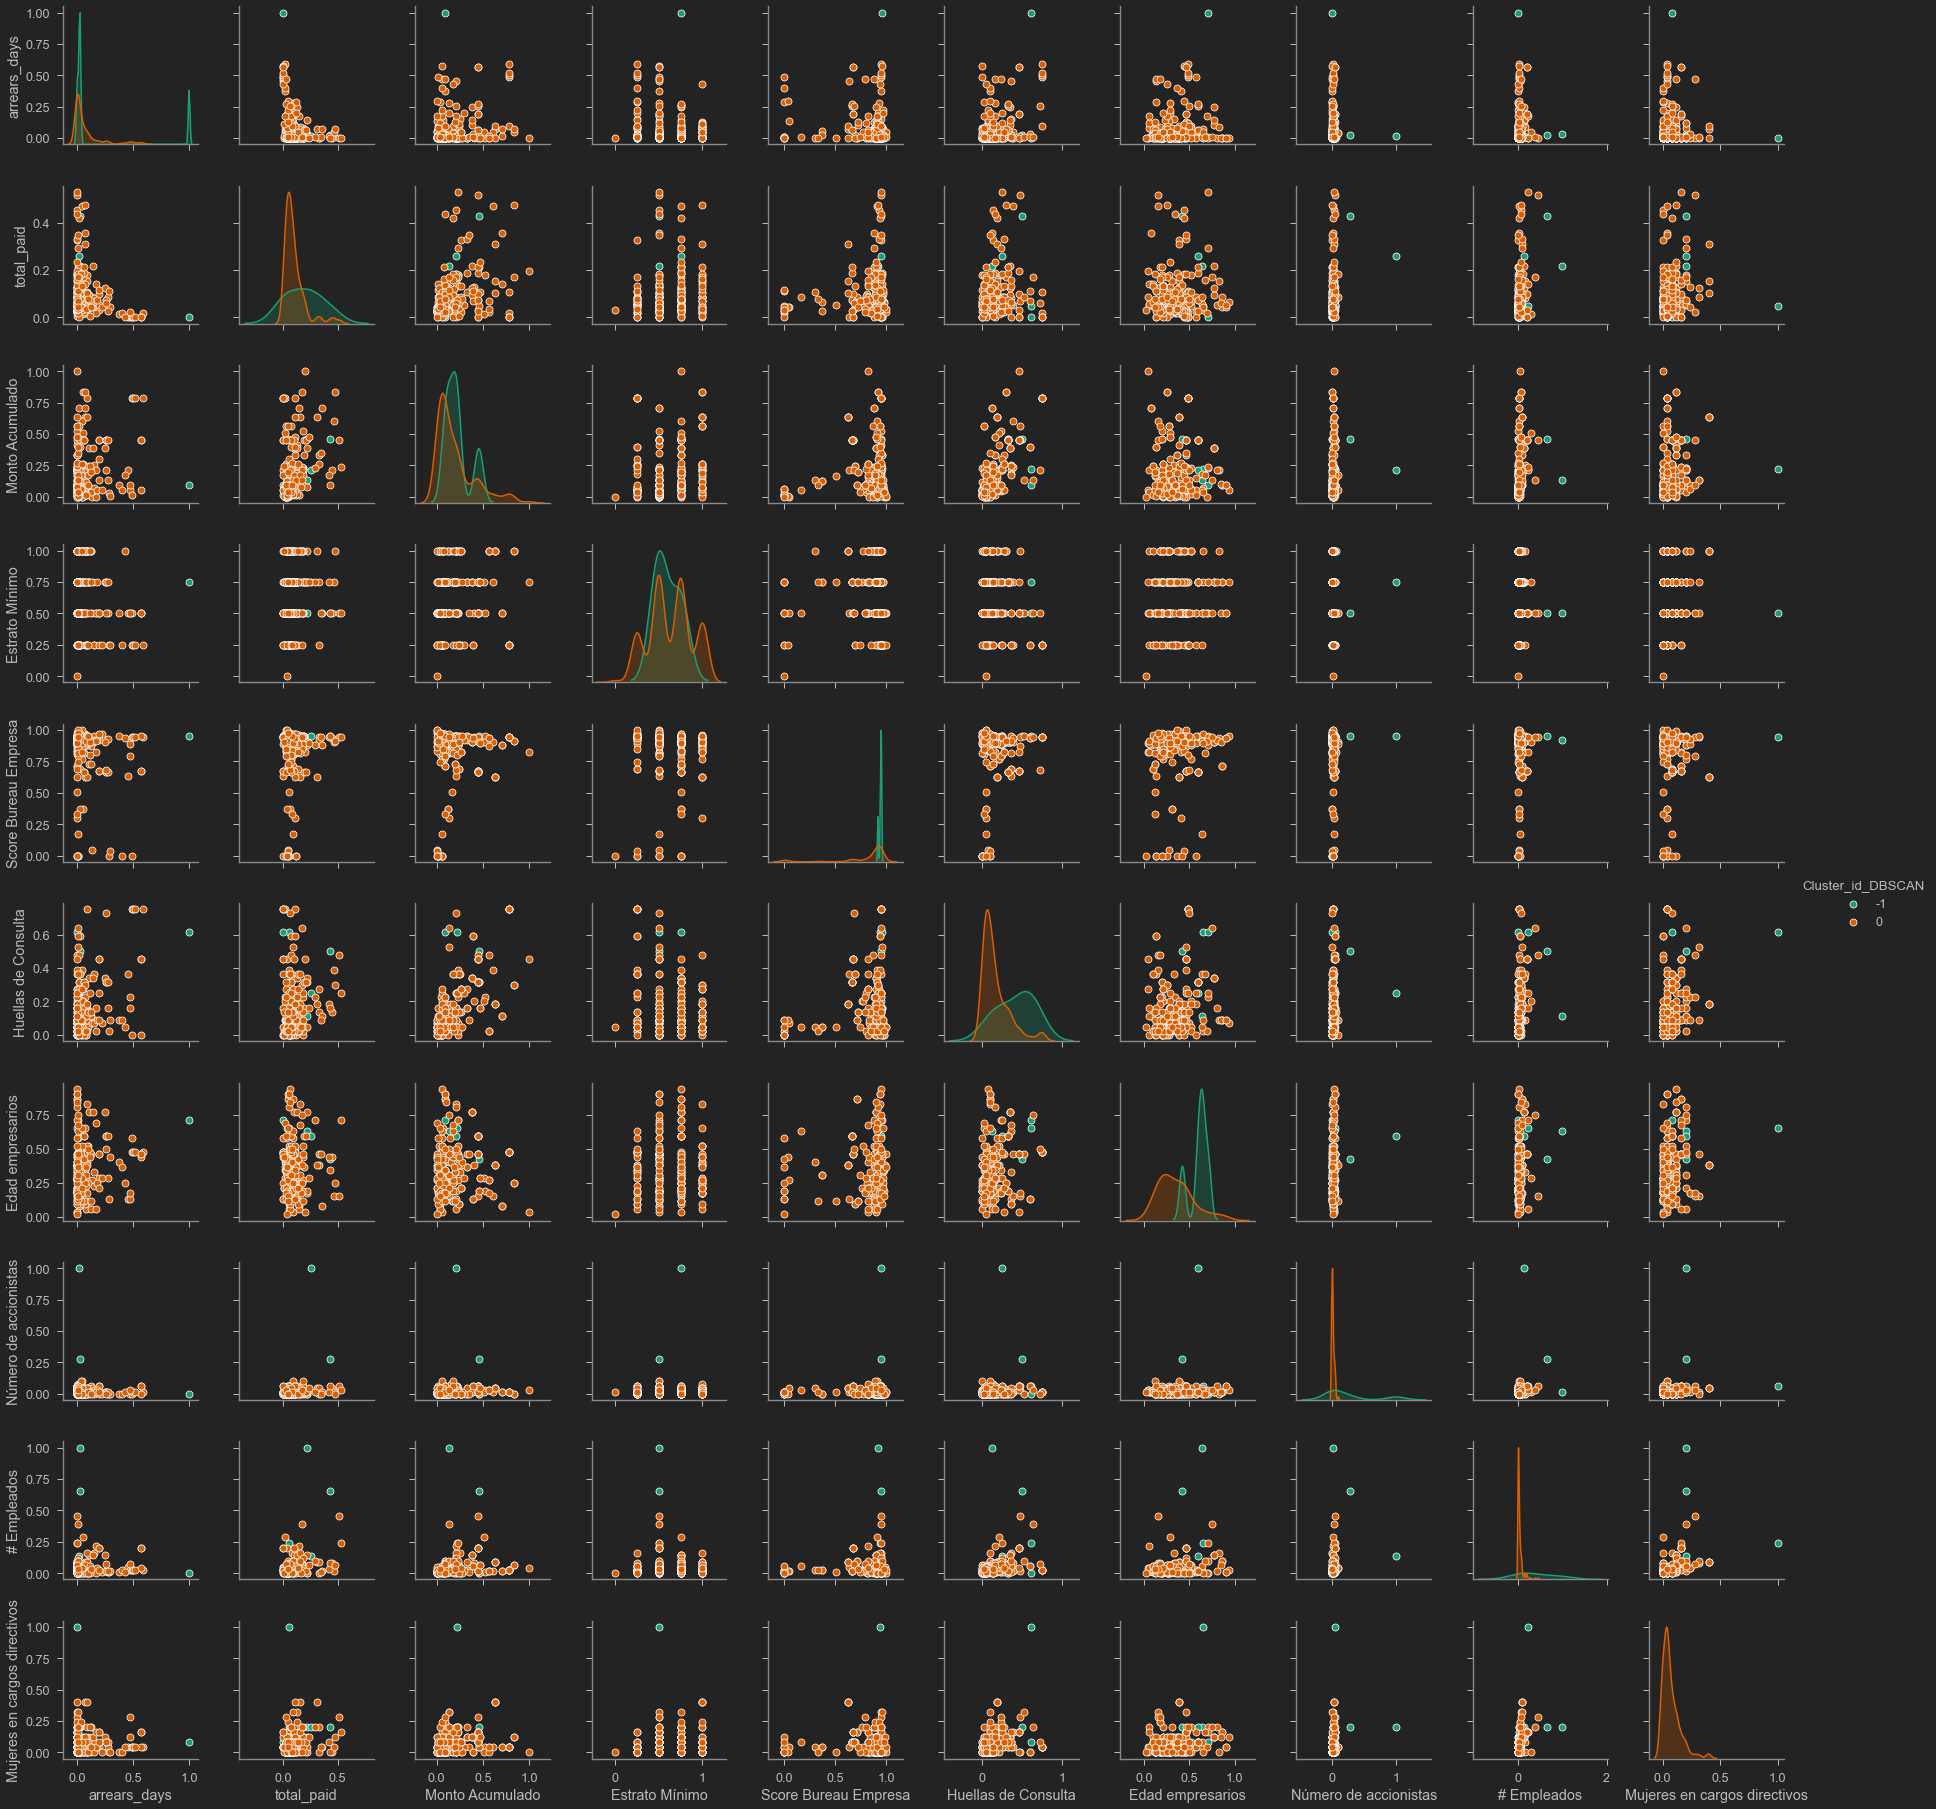

In [185]:
#Visualize DBSCAN clustering 
df_DBSCAN=Data_DBSCAN
df_DBSCAN['Cluster_id_DBSCAN']=results
print (df_DBSCAN['Cluster_id_DBSCAN'].value_counts())
sns.pairplot(df_DBSCAN,hue='Cluster_id_DBSCAN',palette='Dark2',diag_kind='kde')

In [194]:
Data.columns

Index(['state', 'arrears_days', 'total_paid', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

##### Kprototype Clustering Algorithm

In [195]:
#Selection of variables for Kprototype Clustering Algorithm
#Data_k= Data[['state','arrears_days','total_paid', 'Score Bureau Empresa']]
Data_k = Data[['state', 'arrears_days', 'total_paid', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos']]
print (Data_k.dtypes)

state                            object
arrears_days                    float64
total_paid                      float64
Monto Acumulado                 float64
Uso de los recursos              object
Plazo                            object
Sector                           object
Ingresos                         object
Ubicación                        object
Estrato Mínimo                  float64
Procesos judiciales              object
Alertas                          object
Score Bureau Empresa            float64
Huellas de Consulta             float64
Website empresa                  object
Instagram empresa                object
LinkedIn empresa                 object
LinkedIn empresarios             object
Edad empresarios                float64
Activador                        object
Número de accionistas           float64
Impacto                          object
Acceso previso a la banca        object
# Empleados                     float64
Mujeres empresarias              object


In [204]:
i=0
for val in range(len(Data_k.columns)):
    print(f'indice {i}: {Data_k.columns[val]}')
    i+= 1

indice 0: state
indice 1: arrears_days
indice 2: total_paid
indice 3: Monto Acumulado
indice 4: Uso de los recursos
indice 5: Plazo
indice 6: Sector
indice 7: Ingresos
indice 8: Ubicación
indice 9: Estrato Mínimo
indice 10: Procesos judiciales
indice 11: Alertas
indice 12: Score Bureau Empresa
indice 13: Huellas de Consulta
indice 14: Website empresa
indice 15: Instagram empresa
indice 16: LinkedIn empresa
indice 17: LinkedIn empresarios
indice 18: Edad empresarios
indice 19: Activador
indice 20: Número de accionistas
indice 21: Impacto
indice 22: Acceso previso a la banca
indice 23: # Empleados
indice 24: Mujeres empresarias
indice 25: Mujeres en cargos directivos


In [205]:
categorical_columns = [0, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16,
                      17,19, 21, 22, 24, 25] #make sure to specify correct indices

<function matplotlib.pyplot.show(*args, **kw)>

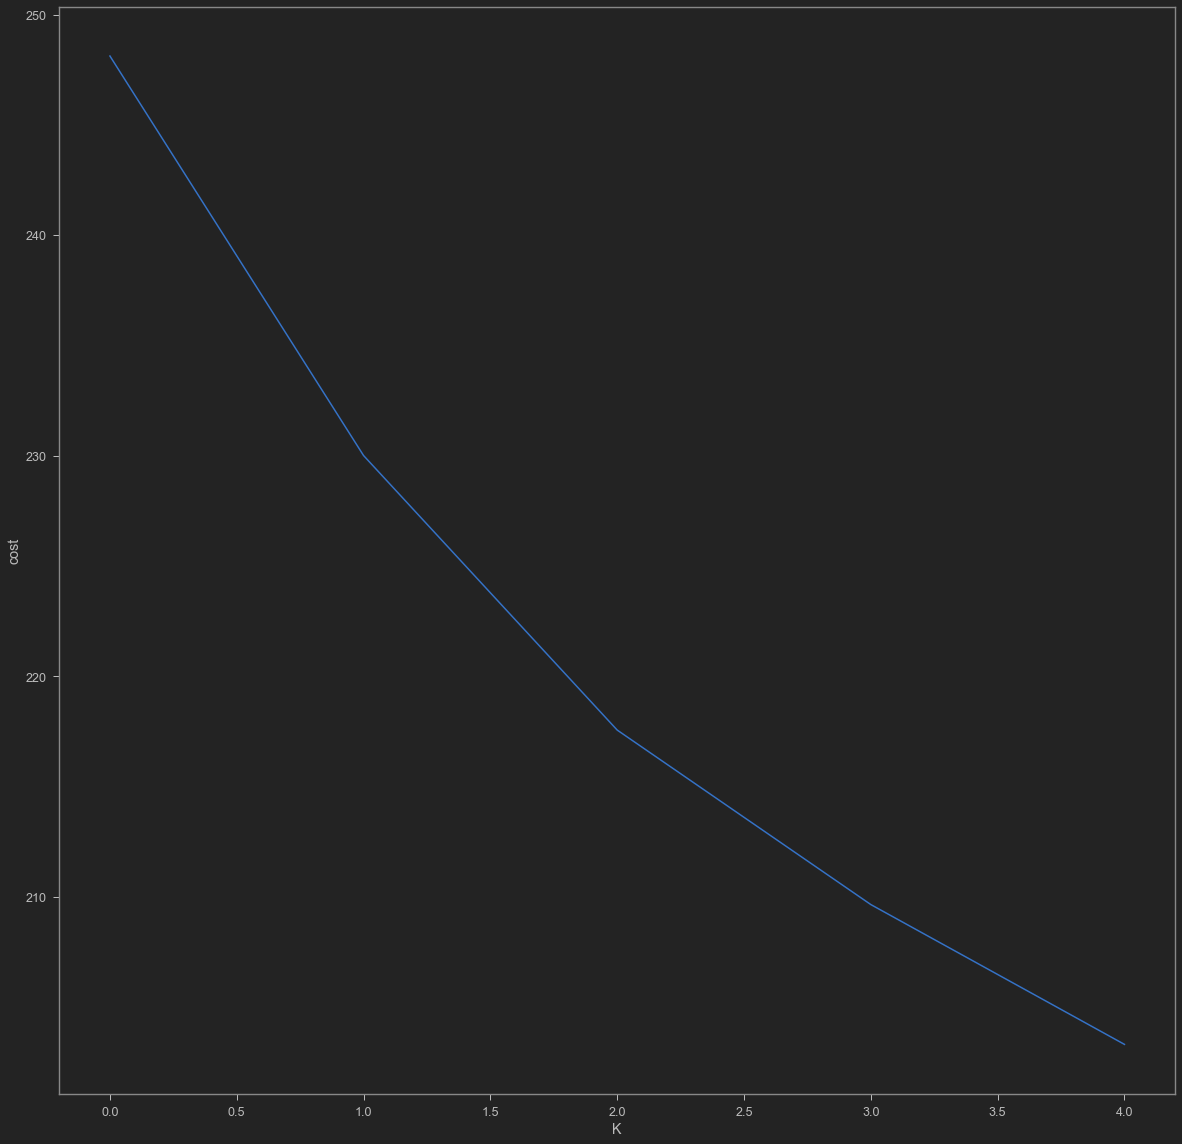

In [206]:
#Choosing optimal K value
cost = []
X = Data_k
for num_clusters in list(range(2,7)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=1,max_iter=15,n_init=50) 
    kproto.fit_predict(X, categorical=categorical_columns)
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [207]:
# Converting the dataset into matrix
X = Data_k.to_numpy()

In [208]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=0.15) 
clusters = kproto.fit_predict(X, categorical=categorical_columns)

0    120
1     80
Name: Cluster_id_K_Prototype, dtype: int64


Default bandwidth for data is 0; skipping density estimation.


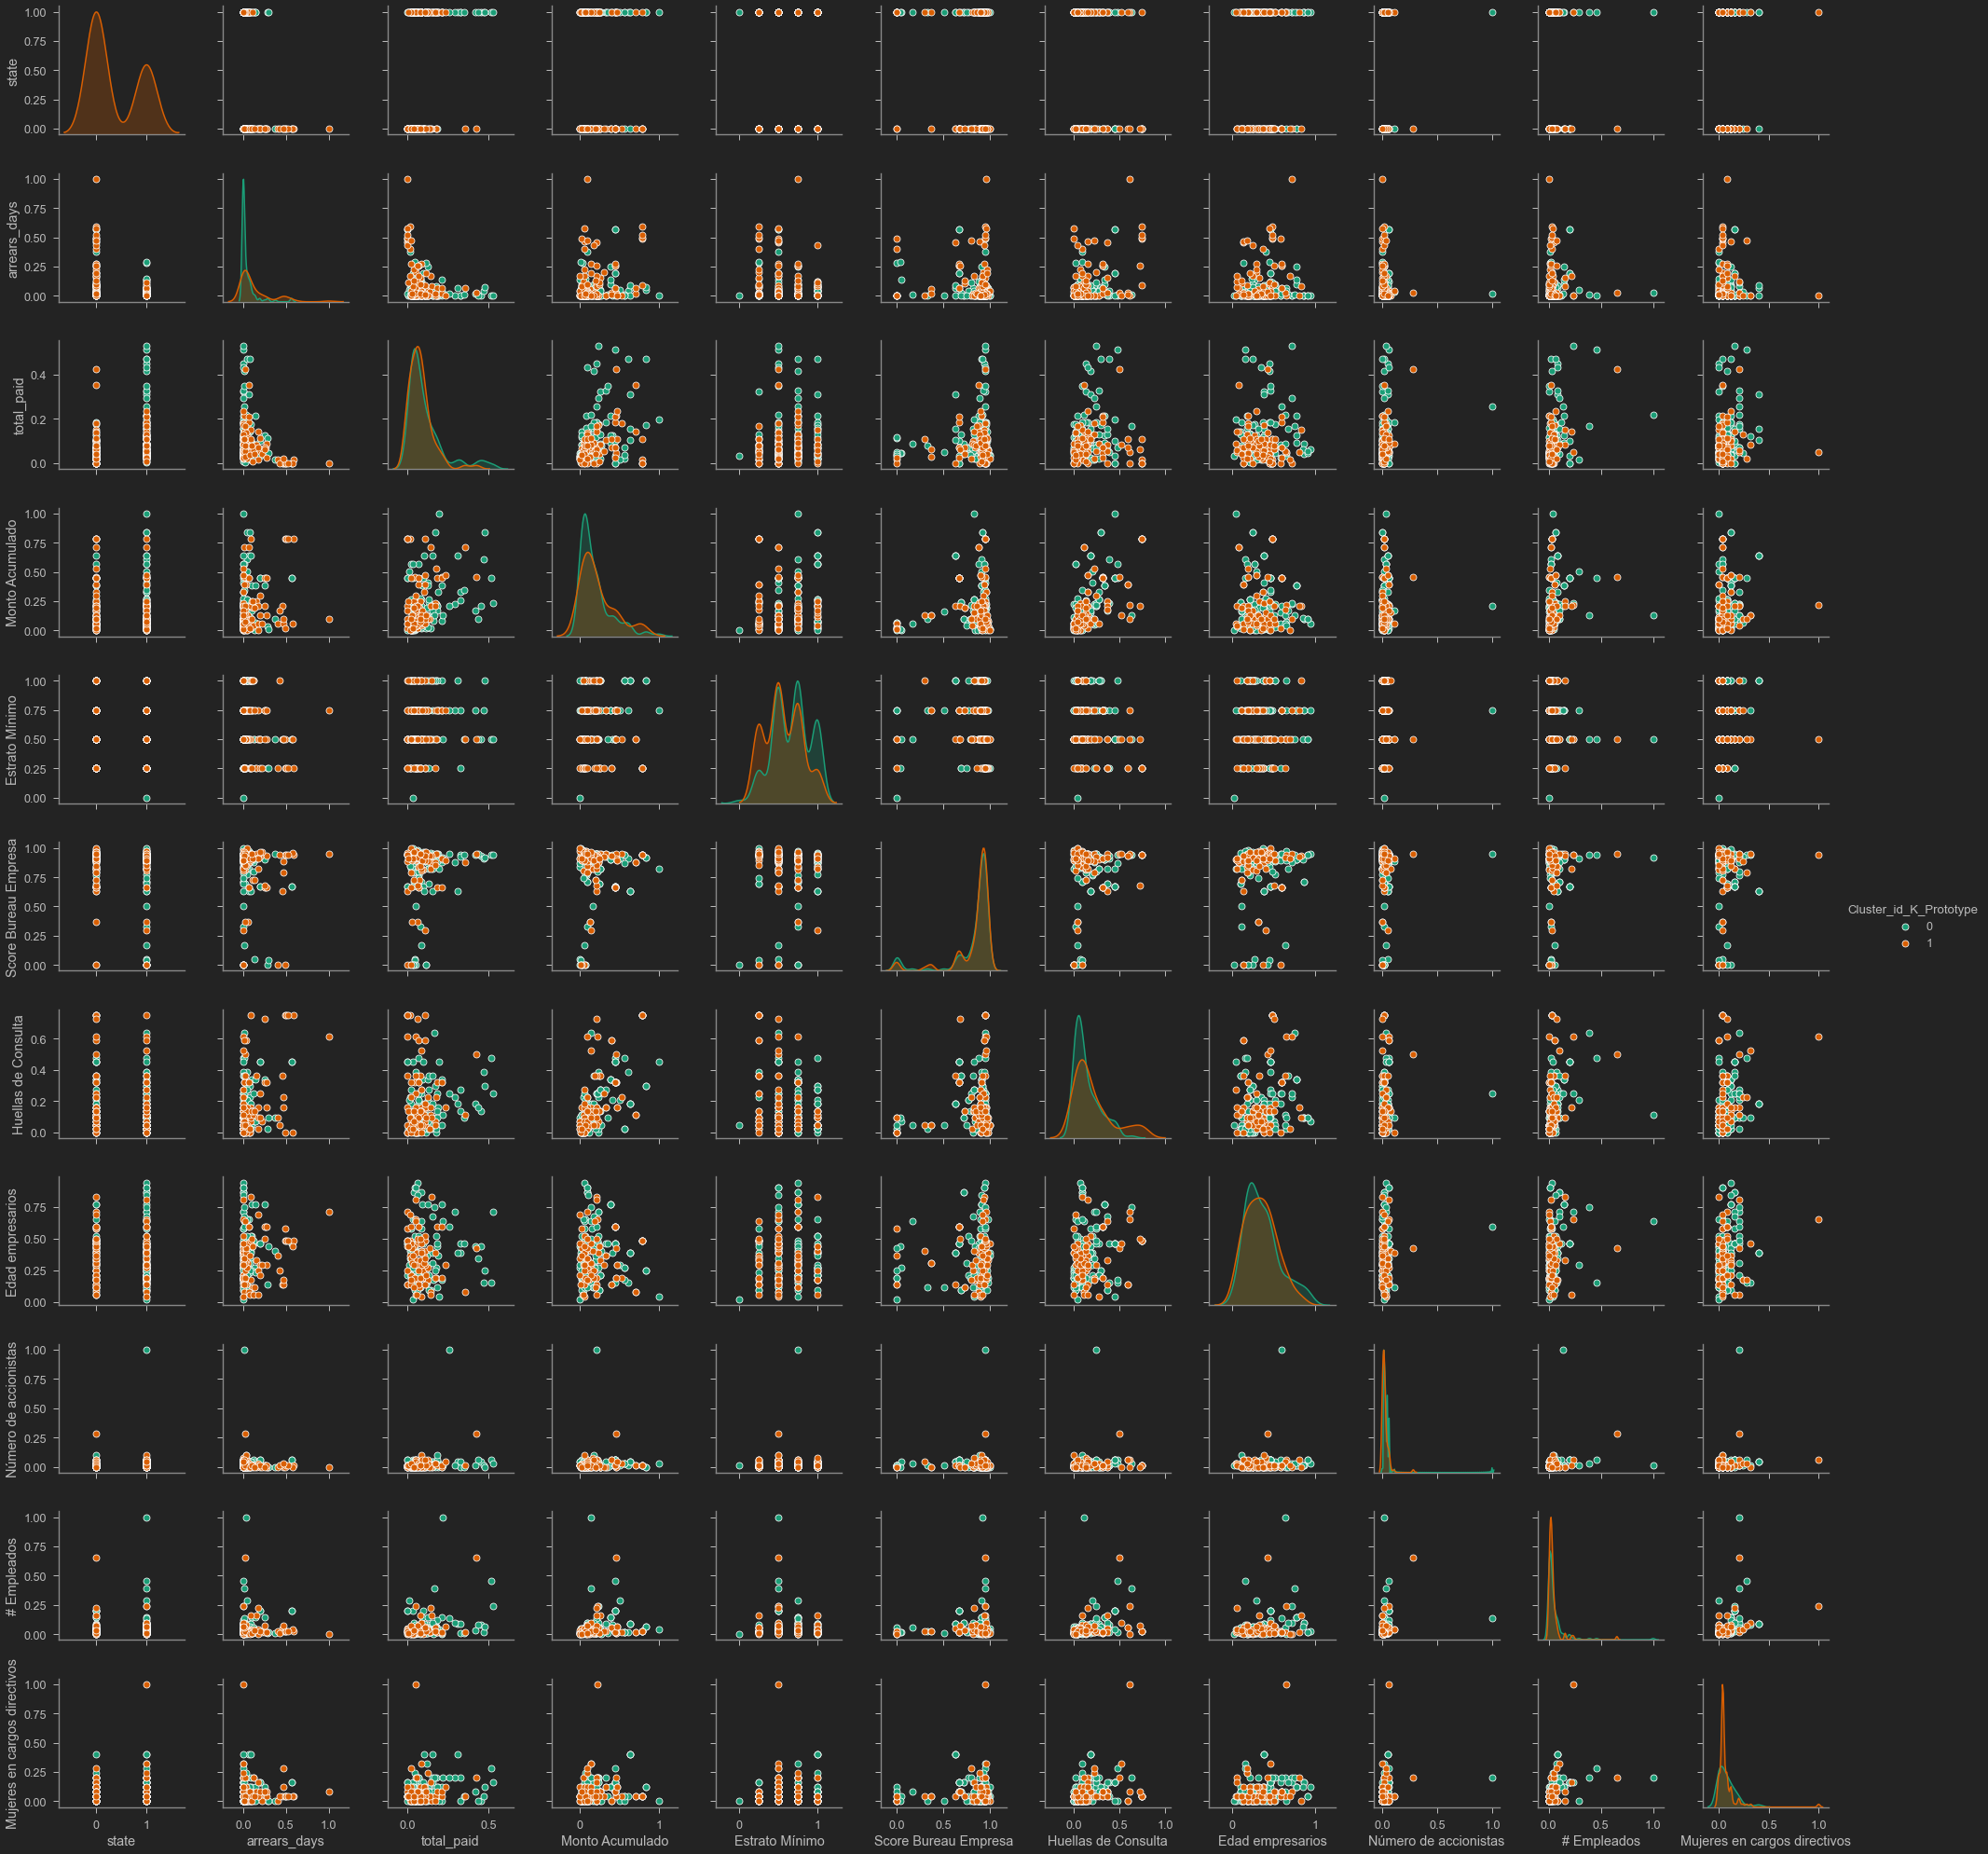

In [209]:
#Visualize K-Prototype clustering 
df_state=pd.DataFrame(Data_k)
df_state['Cluster_id_K_Prototype']=clusters
print (df_state['Cluster_id_K_Prototype'].value_counts())
sns.pairplot(df_state,hue='Cluster_id_K_Prototype',palette='Dark2',diag_kind='kde')
plt.show()

In [212]:
df_state.head(1)

,,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos,Cluster_id_K_Prototype
client_id,loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
4179,1239,0,0.376731,0.015856,0.094535,CR,25 a 36 meses,Industria,Seed,Medellín,0.5,No,No,0.949084,0.090909,No,Si,No,Si,0.403846,FriendOrColleague,0.0,Si,Si,0.01002,No,0.0,0


##### Grupo 1

In [210]:
#Selection of variables for Kprototype Clustering Algorithm
Data_k= Data[['state','arrears_days','total_paid', 'Score Bureau Empresa']]
print (Data_k.dtypes)

state                    object
arrears_days            float64
total_paid              float64
Score Bureau Empresa    float64
dtype: object


0    120
1     80
Name: Cluster_id, dtype: int64


Data must have variance to compute a kernel density estimate.
Data must have variance to compute a kernel density estimate.


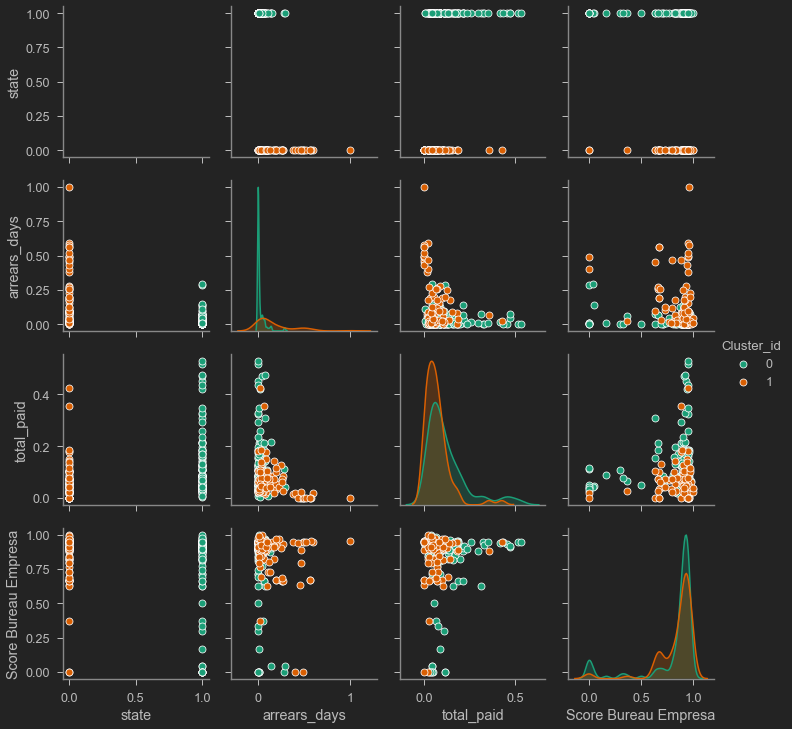

In [211]:
# Converting the dataset into matrix
X = Data_k.to_numpy()
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=0.15) 
clusters = kproto.fit_predict(X, categorical=[0])
#Visualize K-Prototype clustering
df=pd.DataFrame(Data_k)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

#### Grupo 2

In [210]:
#Selection of variables for Kprototype Clustering Algorithm
Data_k= Data[['state','arrears_days','total_paid', 'Score Bureau Empresa']]
print (Data_k.dtypes)

state                    object
arrears_days            float64
total_paid              float64
Score Bureau Empresa    float64
dtype: object


0    120
1     80
Name: Cluster_id, dtype: int64


Data must have variance to compute a kernel density estimate.
Data must have variance to compute a kernel density estimate.


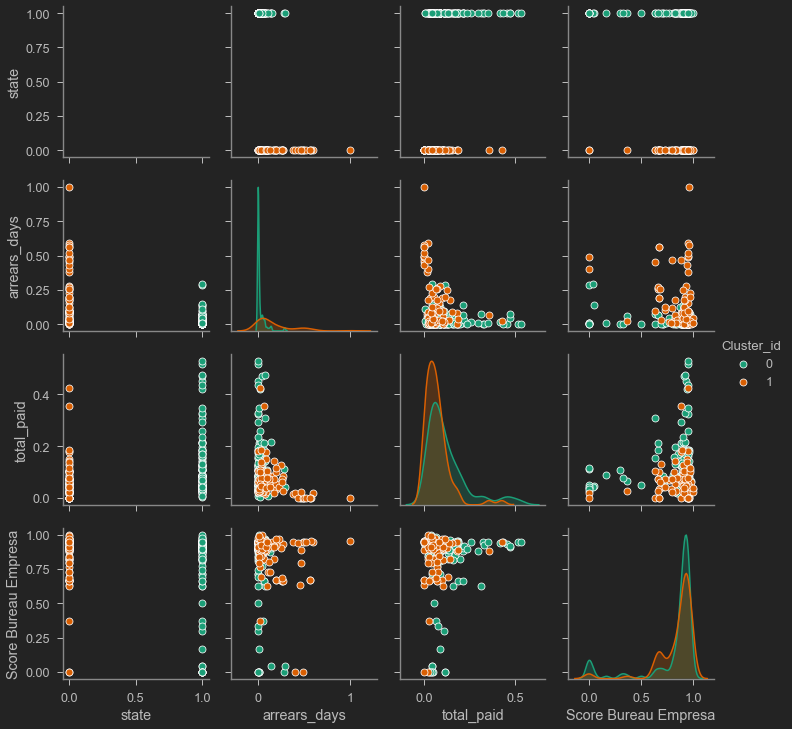

In [211]:
# Converting the dataset into matrix
X = Data_k.to_numpy()
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=0.15) 
clusters = kproto.fit_predict(X, categorical=[0])
#Visualize K-Prototype clustering
df=pd.DataFrame(Data_k)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

#### Grupo 3

In [210]:
#Selection of variables for Kprototype Clustering Algorithm
Data_k= Data[['state','arrears_days','total_paid', 'Score Bureau Empresa']]
print (Data_k.dtypes)

state                    object
arrears_days            float64
total_paid              float64
Score Bureau Empresa    float64
dtype: object


0    120
1     80
Name: Cluster_id, dtype: int64


Data must have variance to compute a kernel density estimate.
Data must have variance to compute a kernel density estimate.


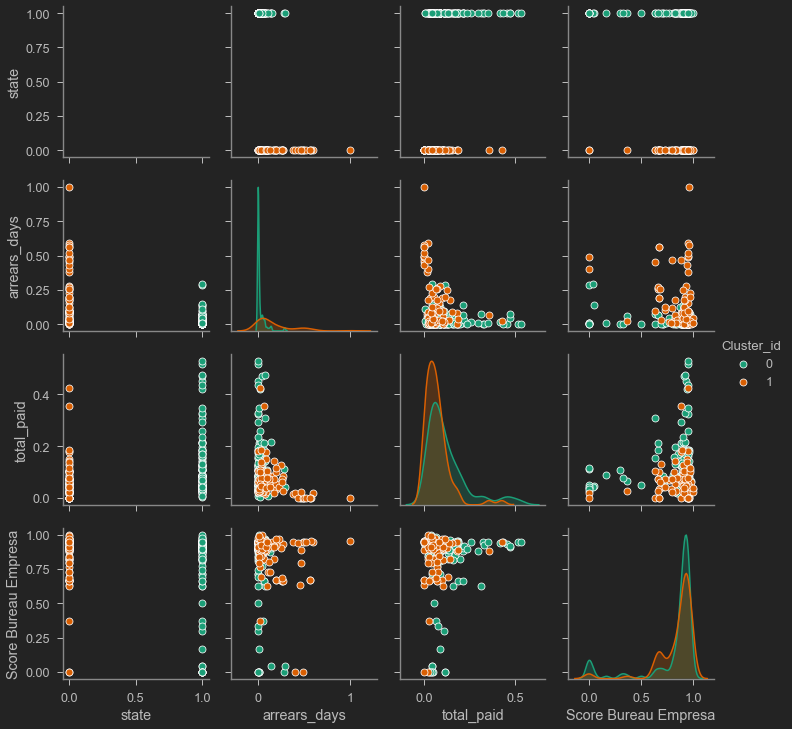

In [211]:
# Converting the dataset into matrix
X = Data_k.to_numpy()
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=0.15) 
clusters = kproto.fit_predict(X, categorical=[0])
#Visualize K-Prototype clustering
df=pd.DataFrame(Data_k)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

#### Grupo 4

In [210]:
#Selection of variables for Kprototype Clustering Algorithm
Data_k= Data[['state','arrears_days','total_paid', 'Score Bureau Empresa']]
print (Data_k.dtypes)

state                    object
arrears_days            float64
total_paid              float64
Score Bureau Empresa    float64
dtype: object


0    120
1     80
Name: Cluster_id, dtype: int64


Data must have variance to compute a kernel density estimate.
Data must have variance to compute a kernel density estimate.


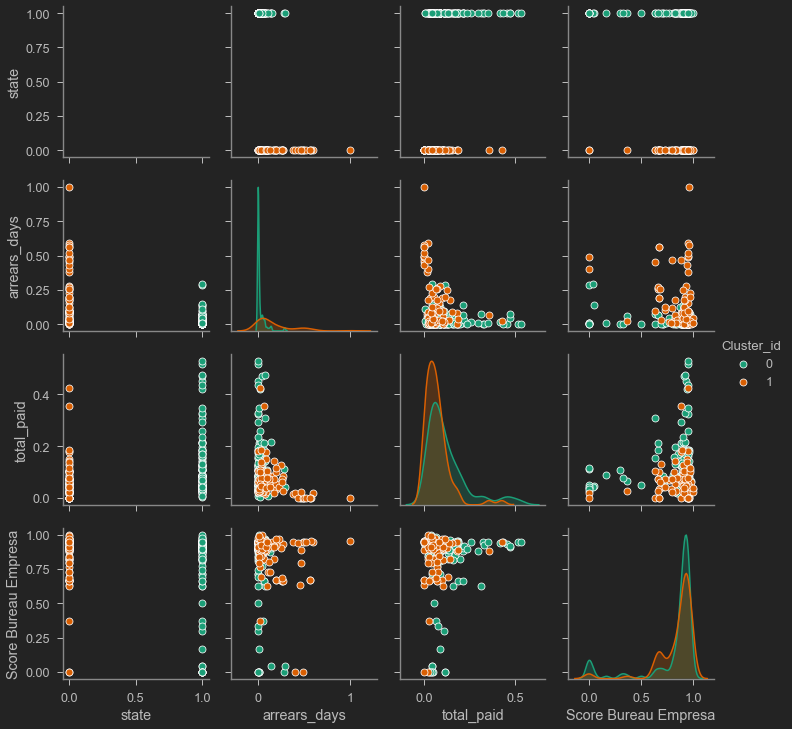

In [211]:
# Converting the dataset into matrix
X = Data_k.to_numpy()
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=0.15) 
clusters = kproto.fit_predict(X, categorical=[0])
#Visualize K-Prototype clustering
df=pd.DataFrame(Data_k)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

#### Cluster Agreement

In [214]:
df_state.head(1)

,,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos,Cluster_id_K_Prototype
client_id,loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
4179,1239,0,0.376731,0.015856,0.094535,CR,25 a 36 meses,Industria,Seed,Medellín,0.5,No,No,0.949084,0.090909,No,Si,No,Si,0.403846,FriendOrColleague,0.0,Si,Si,0.01002,No,0.0,0


In [215]:
df_DBSCAN.head(1)

,,arrears_days,total_paid,Monto Acumulado,Estrato Mínimo,Score Bureau Empresa,Huellas de Consulta,Edad empresarios,Número de accionistas,# Empleados,Mujeres en cargos directivos,Cluster_id_DBSCAN
client_id,loan_id,,,,,,,,,,,
4179,1239,0.376731,0.015856,0.094535,0.5,0.949084,0.090909,0.403846,0.0,0.01002,0.0,0


In [216]:
Data

,,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
client_id,loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,
4179,1239,0,0.376731,0.015856,0.094535,CR,25 a 36 meses,Industria,Seed,Medellín,0.50,No,No,0.949084,0.090909,No,Si,No,Si,0.403846,FriendOrColleague,0.000000,Si,Si,0.010020,No,0.00
2440,662,1,0.056325,0.063620,0.128519,KT - EX,13 a 24 meses,Servicios,Seed,Bogotá D.C.,0.75,No,No,0.368635,0.045455,Si,Si,No,No,0.307692,Other,0.000000,No,Si,0.022044,Si,0.04
3262,1440,1,0.000000,0.042900,0.094535,KT - EX,13 a 24 meses,Servicios,Scale Up,Bogotá D.C.,0.75,No,Si,0.713849,0.090909,Si,Si,Si,Si,0.865385,Internet,0.014706,No,Si,0.098196,No,0.16
1663,971,0,0.151431,0.083093,0.252093,CR,Menos de 12 meses,Industria,Scale Up,Itagüí,0.25,No,No,0.950102,0.363636,No,No,No,No,0.326923,CreditProfessionalContact,0.000000,No,Si,0.158317,No,0.08
2460,688,1,0.002770,0.187034,0.330873,CR,13 a 24 meses,Comercio,Scale Up,Medellín,0.75,No,No,0.954175,0.159091,No,No,No,Si,0.365385,CreditProfessionalContact,0.000000,No,Si,0.028056,No,0.12
3423,1115,0,0.015697,0.070427,0.078779,KT - EX,13 a 24 meses,Servicios,Seed,Bogotá D.C.,0.75,No,No,0.765784,0.204545,Si,Si,Si,Si,0.211538,FriendOrColleague,0.029412,No,Si,0.022044,Si,0.20
2454,682,1,0.002770,0.047138,0.039390,KT - EX,Menos de 12 meses,Servicios,Seed,Medellín,0.75,No,No,0.893075,0.022727,No,No,No,No,0.096154,FriendOrColleague,0.014706,No,No,0.008016,Si,0.12
3639,1267,0,0.092336,0.066383,0.015756,KT - CO,Menos de 12 meses,Comercio,Scale Up,Bogotá D.C.,0.50,Si,No,0.941955,0.159091,Si,No,Si,No,0.461538,FriendOrColleague,0.014706,No,Si,0.014028,No,0.00
2461,1422,1,0.000000,0.068639,0.102413,KT - CO,Menos de 12 meses,Servicios,Seed,Medellín,0.50,No,No,0.893075,0.181818,Si,Si,Si,Si,0.173077,FriendOrColleague,0.000000,No,Si,0.034068,No,0.08


In [219]:
len(Clusters.columns)

64

In [243]:
#join DBScan and K-prototype data frames
Clusters=pd.concat([df_state, Data, df_DBSCAN], axis = 1)
Clusters=Clusters.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 63]]
Clusters.head()

,,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos,Cluster_id_K_Prototype,Cluster_id_DBSCAN
client_id,loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4179,1239,0,0.376731,0.015856,0.094535,CR,25 a 36 meses,Industria,Seed,Medellín,0.50,No,No,0.949084,0.090909,No,Si,No,Si,0.403846,FriendOrColleague,0.000000,Si,Si,0.010020,No,0.00,0,0
2440,662,1,0.056325,0.063620,0.128519,KT - EX,13 a 24 meses,Servicios,Seed,Bogotá D.C.,0.75,No,No,0.368635,0.045455,Si,Si,No,No,0.307692,Other,0.000000,No,Si,0.022044,Si,0.04,1,0
3262,1440,1,0.000000,0.042900,0.094535,KT - EX,13 a 24 meses,Servicios,Scale Up,Bogotá D.C.,0.75,No,Si,0.713849,0.090909,Si,Si,Si,Si,0.865385,Internet,0.014706,No,Si,0.098196,No,0.16,0,0
1663,971,0,0.151431,0.083093,0.252093,CR,Menos de 12 meses,Industria,Scale Up,Itagüí,0.25,No,No,0.950102,0.363636,No,No,No,No,0.326923,CreditProfessionalContact,0.000000,No,Si,0.158317,No,0.08,1,0
2460,688,1,0.002770,0.187034,0.330873,CR,13 a 24 meses,Comercio,Scale Up,Medellín,0.75,No,No,0.954175,0.159091,No,No,No,Si,0.365385,CreditProfessionalContact,0.000000,No,Si,0.028056,No,0.12,0,0


In [245]:
i=0
for val in range(len(Data.columns)):
    print(f'indice {i}: {Data.columns[val]}')
    i+= 1

indice 0: state
indice 1: arrears_days
indice 2: total_paid
indice 3: Monto Acumulado
indice 4: Uso de los recursos
indice 5: Plazo
indice 6: Sector
indice 7: Ingresos
indice 8: Ubicación
indice 9: Estrato Mínimo
indice 10: Procesos judiciales
indice 11: Alertas
indice 12: Score Bureau Empresa
indice 13: Huellas de Consulta
indice 14: Website empresa
indice 15: Instagram empresa
indice 16: LinkedIn empresa
indice 17: LinkedIn empresarios
indice 18: Edad empresarios
indice 19: Activador
indice 20: Número de accionistas
indice 21: Impacto
indice 22: Acceso previso a la banca
indice 23: # Empleados
indice 24: Mujeres empresarias
indice 25: Mujeres en cargos directivos


Analizar los acuerdos de clúster entre DBSCAN y K-prototype para 10 pares de valores aleatorios. 

In [259]:
#Verify if randow rows have the same cluster Id between DBScan and K-Prototype
random_rows=Clusters.sample(20,random_state=36)
random_rows.iloc[:, [0,1,2,7,12,13,26,27]]


,,state,arrears_days,total_paid,Ingresos,Score Bureau Empresa,Huellas de Consulta,Cluster_id_K_Prototype,Cluster_id_DBSCAN
client_id,loan_id,,,,,,,,
2924,1073,1,0.029548,0.217307,Growth,0.918534,0.113636,0,-1
1628,710,1,0.285319,0.113377,Venture,0.000000,0.022727,0,0
2470,585,1,0.000923,0.044933,Seed,0.918534,0.090909,0,0
4468,1315,0,0.082179,0.036946,Seed,0.912424,0.022727,1,0
1743,837,0,0.024931,0.426279,Scale Up,0.950102,0.500000,1,-1
4728,1319,1,0.016620,0.257610,Growth,0.950102,0.250000,0,-1
5309,1377,1,0.011080,0.168574,Growth,0.946029,0.636364,0,0
2959,1072,0,1.000000,0.000000,Growth,0.954175,0.613636,1,-1
6982,1503,0,0.003693,0.102713,Venture,0.908350,0.113636,1,0


Lo anterior fueron 20 filas aleatorias de datos con los identificadores de grupo de ambos modelos. 

In [ ]:
# OneHotEncoding para variables categoricas
column_trans = make_column_transformer(
    (OneHotEncoder(), columnas_OHE),
    remainder='passthrough')

#normalizada = column_trans.fit_transform(data_transform)

In [109]:
#Preprocessing numerical
numerical = data_transform_2.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = data_transform_2.select_dtypes(include='object')
#print(categorical)
#label_encoder = preprocessing.LabelEncoder()
le = preprocessing.LabelEncoder()
categorical= categorical[columnas_OHE].apply(le.fit_transform)
#categorical = label_encoder.fit(categorical)

#categorical = column_trans.fit_transform(categorical)

#categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(data_transform_2.select_dtypes(include='object').columns) / data_transform_2.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [110]:
categorical_weight

0.6153846153846154

In [ ]:
categorical_weight

In [ ]:
categorical_weight

### get_dummies

In [ ]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

### OneHotEncoding

In [ ]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

#### LabelEnconder

In [ ]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

### Elbow method

In [ ]:
data = pd.get_dummies(data_transform)

In [ ]:
scores = []
# Set index
#normalizada.set_index(['client_id', 'loan_id'], inplace=True)
# Los valores nulos se reemplazan por el promedio de los valores
#normalizada.fillna(normalizada.mean(), inplace=True)

for k in range(1,11):
    km = KMeans(n_clusters=k,random_state=1)
    km = km.fit(data)
    scores.append(km.inertia_)

dfk = pd.DataFrame({'Cluster':range(1,11), 'Score':scores})
plt.figure(figsize=(8,5))
plt.plot(dfk['Cluster'], dfk['Score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
data = pd.get_dummies(data_transform)
for c in data.columns:
    pt = PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

In [ ]:
#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.show()

In [262]:
data_transform_2

state  arrears_days  total_paid  Monto Acumulado Uso de los recursos          Plazo     Sector Ingresos    Ubicación  Estrato Mínimo Procesos judiciales Alertas  Score Bureau Empresa  Huellas de Consulta Website empresa Instagram empresa LinkedIn empresa LinkedIn empresarios  Edad empresarios                  Activador  Número de accionistas Impacto Acceso previso a la banca  # Empleados Mujeres empresarias  Mujeres en cargos directivos
client_id loan_id                                                                                                                                                                                                                                                                                                                                                                                                                                                         
241       1076     PAID            17   147915805        250000000                 CR   25 a 36 meses  Servicios     Seed     Medellín               5                  No      No                   925                    8              Si                Si               Si                   Si                45                   Internet                      2      No                        Si           16                  No                             2
          1244     PAID            23    91852726        250000000                 CR   25 a 36 meses  Servicios     Seed     Medellín               5                  No      No                   925                    8              Si                Si               Si                   Si                45                   Internet                      2      No                        Si           16                  No                             2
362       1469     PAID            14    15211138         50000000             KT - EX  13 a 24 meses  Servicios     Seed     Medellín               3                  No      No                   924                    2              Si                No               Si                   No                32             SocialNetworks                      3      No                        Si            3                  No                             0
428       119      PAID            64     8713879         40000000                  SP  13 a 24 meses  Industria     Seed     Medellín               4                  No      No                   861                    1              Si                No               Si                   Si                44  CreditProfessionalContact                      2      No                        Si            5                  No                             0
          120      PAID            64     8102608         40000000                  SP  13 a 24 meses  Industria     Seed     Medellín               4                  No      No                   861                    1              Si                No               Si                   Si                44  CreditProfessionalContact                      2      No                        Si            5                  No                             0
...                 ...           ...         ...              ...                 ...            ...        ...      ...          ...             ...                 ...     ...                   ...                  ...             ...               ...              ...                  ...               ...                        ...                    ...     ...                       ...          ...                 ...                           ...
6734      1499     LATE            29    16038476         50000000             KT - CO  13 a 24 meses  Servicios     Seed  Bogotá D.C.               5                  No      No                   967                    2              Si                Si               No                   Si                39             SocialNetworks        

### K-prototypes

In [263]:
kprot_data = data_transform_2.copy()
for c in data_transform.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

In [264]:
kprot_data_array = kprot_data.values

In [ ]:
#categorical_columns = [1, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16,
#                      17, 18, 20, 21, 22, 23, 25] #make sure to specify correct indices

In [295]:
kproto_3 = KPrototypes(n_clusters= 3, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_3 = kproto_3.fit_predict(kprot_data_array, categorical=categorical_columns)

Best run was number 1


In [296]:
kproto_2 = KPrototypes(n_clusters= 2, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_2 = kproto_2.fit_predict(kprot_data_array, categorical=categorical_columns)

Best run was number 3


In [307]:
clusters_kproto=pd.DataFrame(data_transform_2)
clusters_kproto['cluster_id_2'] = clusters_2
clusters_kproto['cluster_id_3'] = clusters_3
#clusters_kproto.reset_index(inplace=True)
clusters_kproto.drop(['index', 'level_0'],axis=1, inplace=True)

In [308]:
clusters_kproto.head()

,client_id,loan_id,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos,cluster_id_3,cluster_id_2
0,241,1076,PAID,17,147915805,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2,1,1
1,241,1244,PAID,23,91852726,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2,1,1
2,362,1469,PAID,14,15211138,50000000,KT - EX,13 a 24 meses,Servicios,Seed,Medellín,3,No,No,924,2,Si,No,Si,No,32,SocialNetworks,3,No,Si,3,No,0,2,0
3,428,119,PAID,64,8713879,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0,2,0
4,428,120,PAID,64,8102608,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0,2,0


In [345]:
clusters_kproto.to_csv('clusters.csv')

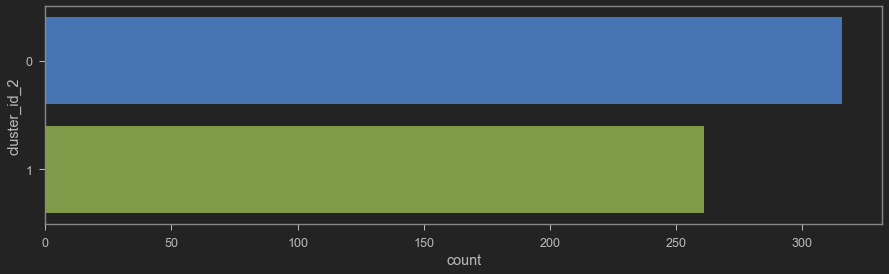

In [343]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_2', data=clusters_kproto)

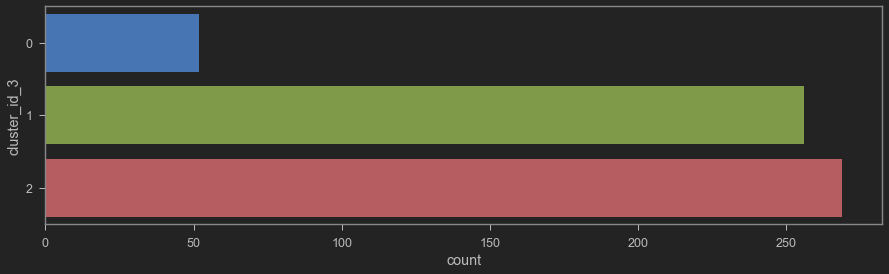

In [344]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_3', data=clusters_kproto)

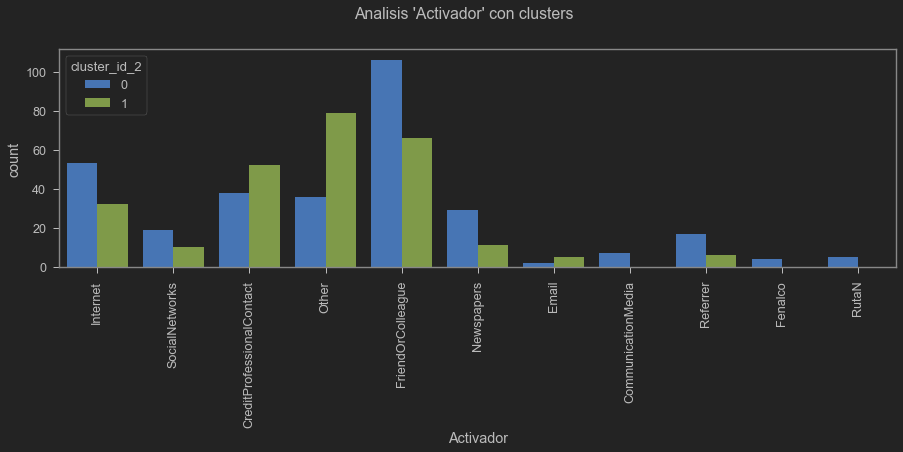

In [330]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', x='Activador', data=clusters_kproto)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

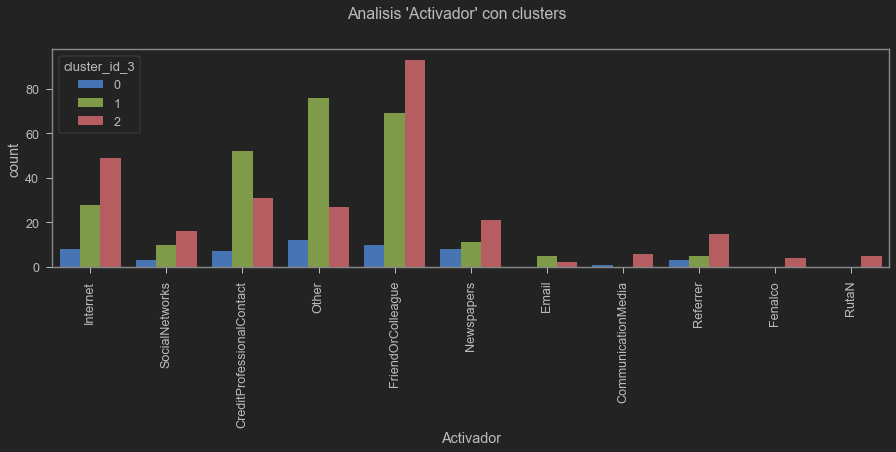

In [334]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', x='Activador', data=clusters_kproto)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

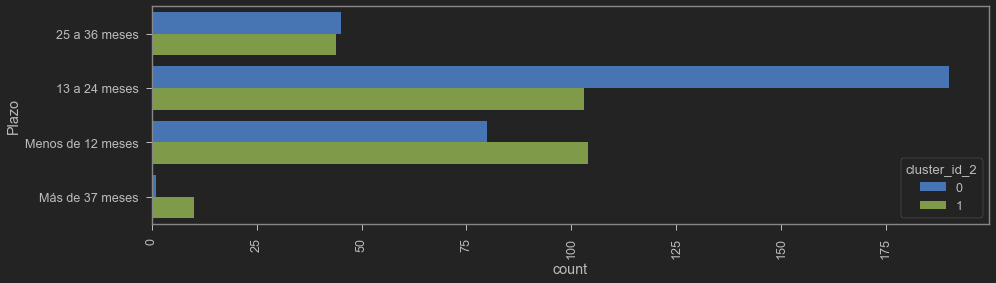

In [332]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', y='Plazo', data=clusters_kproto)
plt.xticks(rotation=90)
plt.show()

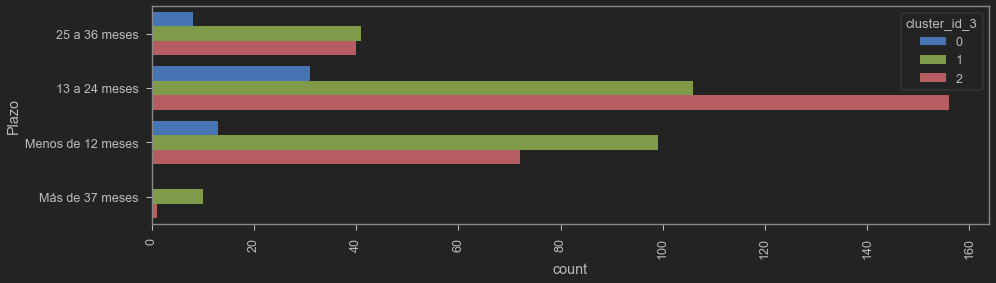

In [333]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', y='Plazo', data=clusters_kproto)
plt.xticks(rotation=90)
plt.show()